<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
* To make my life easier I will remove everything but [a-zA-Z0-9] and whitespaces
* For now I will use a bag-of-words approach as I have limited time

# libraries, constants, etc.

In [16]:
from google.colab import drive

import pandas as pd
import numpy as np
import sklearn.model_selection

import seaborn as sns
from matplotlib import pyplot as plt

import nltk

This should later be put into: requirements installations (in separate requirements file)

In [29]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

# read data


In [2]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
products_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [21]:
products_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

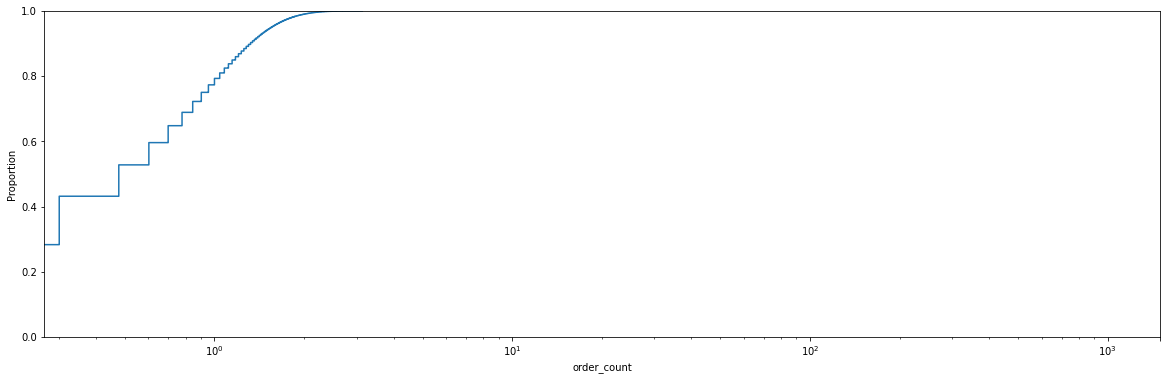

In [22]:
# plot the order count ecdf
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
sns.ecdfplot(
    data=products_df,
    x="order_count",
    ax=ax,
    log_scale=True
)
ax.set_xticks([1, 10, 100, 1000, 1500])
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

# data cleanup

## train test split

In [76]:
# sample data for testing
products_sample_raw_df = products_raw_df.copy() #sample(20000)

In [77]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)

## data normalization

In [10]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [79]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

## basic cleanup

In [80]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy

In [23]:
# drop empty text
products_name_df.dropna(inplace=True)
products_description_df.dropna(inplace=True)

# replace everything but basic chars for now
products_name_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)
products_description_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)

# remove single and double characters
products_name_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_name_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_name_df["text"].replace("[ ]+", " ", inplace=True, regex=True)
products_description_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_name_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_name_df = products_name_df[products_name_df["text"] != ""]

products_description_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_description_df = products_description_df[products_description_df["text"] != ""]

In [24]:
# to lower
products_name_df["text"] = products_name_df["text"].str.lower()
products_description_df["text"] = products_description_df["text"].str.lower()

In [25]:
products_name_df

,product_id,vendor_id,vendor_geohash,text
0,0,0,w21z6tu,cheese tofu
1,1,1,w21z74d,naughty nice slice
2,2,2,w21xxgu,301 pork dumpling with hot chilli vinaigrette
3,3,3,w23b4u1,mee kuah
4,4,4,w21ztq4,ham cheese sandwich set
...,...,...,...,...
633143,633143,701,w21zkpm,sriracha chicken whole wheat pita
633144,633144,17,w23b5j9,dettol liquid hand wash sensitive 250ml
633145,633145,4135,w21ztw0,red bean
633146,633146,3121,w21z6vc,twister meal


In [26]:
products_description_df

,product_id,vendor_id,vendor_geohash,text
1,1,1,w21z74d,chocolate slice
2,2,2,w21xxgu,pcs spicy
3,3,3,w23b4u1,contain minced mutton meat
4,4,4,w21ztq4,toasted perfection this sandwich hits all the ...
7,7,7,w23b1tm,17 great food great value comes with pasta so...
...,...,...,...,...
633138,633138,3817,w21z3m2,pan fried japanese pork belly with sweet sauce...
633141,633141,36,w21zey6,cocomax made from 100 thai coconut water is pu...
633144,633144,17,w23b5j9,dettol liquid hand wash kills germs ensuring ...
633145,633145,4135,w21ztw0,pcs


## tokenization and stemming

In [27]:
products_name_token_df = products_name_df.copy()
products_description_token_df = products_description_df.copy()

In [30]:
# tokenization
products_name_token_df["text_tokens"] = products_name_token_df["text"].transform(nltk.word_tokenize)
products_description_token_df["text_tokens"] = products_description_token_df["text"].apply(nltk.word_tokenize)

In [31]:
# add a position index and explode
products_name_token_df["idx"] = 1
products_name_token_df = products_name_token_df.explode("text_tokens")
products_name_token_df["idx"] = products_name_token_df.groupby(primary_keys)["idx"].cumsum()

products_description_token_df["idx"] = 1
products_description_token_df = products_description_token_df.explode("text_tokens")
products_description_token_df["idx"] = products_description_token_df.groupby(primary_keys)["idx"].cumsum()

In [32]:
# stemming
snowball = nltk.stem.SnowballStemmer(language="english")
products_name_token_df["text_tokens_stemmed"] = products_name_token_df["text_tokens"].apply(lambda x: snowball.stem(x))
products_description_token_df["text_tokens_stemmed"] = products_description_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the fraction of english words in name and description and to use this in some way to filter english items.

In [34]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_name_token_df["is_english"] = products_name_token_df["text_tokens"].isin(words)
products_description_token_df["is_english"] = products_description_token_df["text_tokens"].isin(words)

In [35]:
products_english_df = products_df.copy()

# count english words and total words for product name
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "name_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "name_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# count english words and total words for product description
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "description_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "description_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# replace nans etc. from empty text and cast back to int
for col in ["name_is_english", "name_n_words", "description_is_english", "description_n_words"]:
    products_english_df[col] = products_english_df[col].replace(np.nan, 0).astype(int)

In [48]:
# calculate the actual frequency = score
products_english_df["total_is_english"] = products_english_df["name_is_english"] + products_english_df["description_is_english"]
products_english_df["total_n_words"] = products_english_df["name_n_words"] + products_english_df["description_n_words"]
products_english_df["english_score"] = products_english_df["total_is_english"] / products_english_df["total_n_words"]

In [39]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

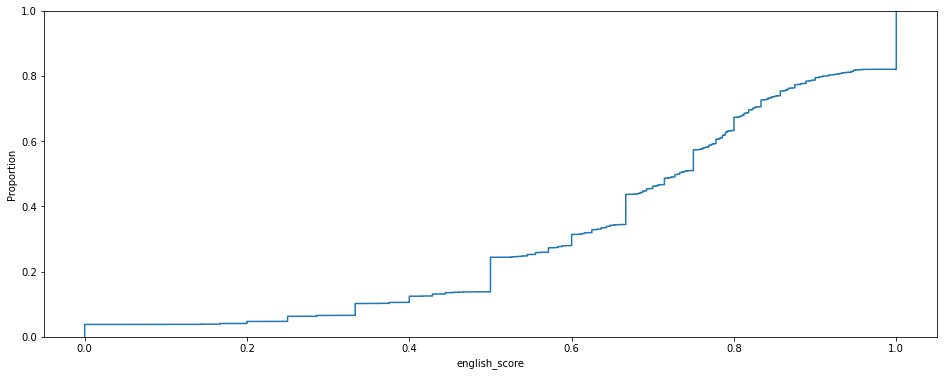

In [58]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

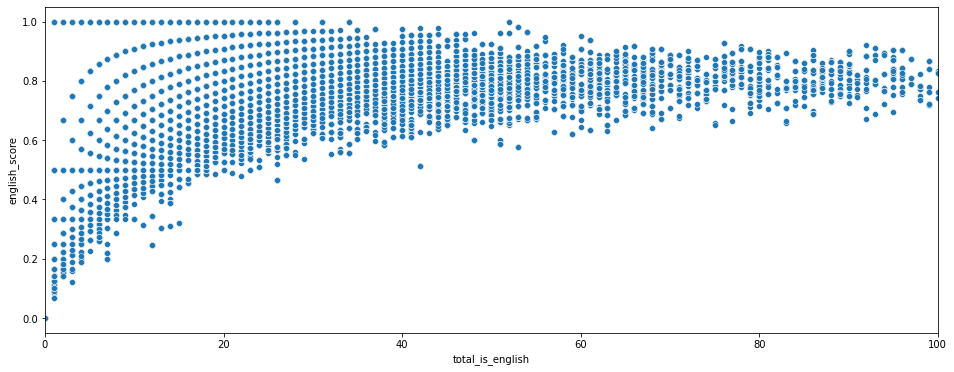

In [64]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.scatterplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

In [46]:
products_raw_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,85,81,w21zsbb,Meiji Mixberry Yoghurt 135g,,75
1,214,180,w21zsbc,SJORA Savers Combo Deal,None,23
2,466,332,w23b1tq,Portuguese Egg Tarts (2 pcs),None,30
3,530,398,w23b1vv,Bak Kwa Pau (5pcs) 肉干包 (5粒),None,23
4,679,61,w21z675,Meiji Mixberry Yoghurt 135g,,88
...,...,...,...,...,...,...
11651,632778,11207,w23b66h,Bak Kut Mee Dry 招牌肉骨面乾,None,22
11652,632850,2302,w21z8dz,Bibim Myeon,Bimbimbap served with noodles instead.,22
11653,632887,1987,w21zsc6,IF27. Mutton Mysore Biriyani,None,22
11654,632988,3579,w21z77s,6 Pieces Boneless Wings,2 flavors,22


In [47]:
products_raw_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
1,11,11,w21z704,Box B: McNuggets (6pc) + McWings (4pc),McWings® or Chicken McNuggets®? Now you don’t ...,25
2,30,30,w21ze47,Meatball Marinara Melt Sub,Comes with a generous helping of Italian-style...,26
3,35,17,w23b5j9,The Silly Greens Fine Bean 150g,Country of Origin: Indonesia,49
4,37,35,w21zs05,3005. Signature Porridge,None,37
...,...,...,...,...,...,...
89210,633105,899,w21zc4y,Buna Shimeji Mushroom 灵芝菇,None,22
89211,633106,1593,w21zby6,Xmas Feast,2 pcs Chicken (Original Recipe / Hot & Crispy)...,22
89212,633129,3431,w21zby3,Azuki Red Bean,None,22
89213,633133,1359,w21zc57,Seafood Fried Rice,None,22


In [70]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,10,10,w21ztrq,Laksa 叻沙,None,64
1,19,19,w23b4j4,Emborg Shredded Mozzarella 200g,,74
2,54,51,w21zg1e,Cookie (3 Pieces),None,23
3,63,60,w21z6ey,Masak Paprik,None,26
4,77,73,w21zsfw,Mee Goreng,None,29
...,...,...,...,...,...,...
24171,633087,1038,w23b1zp,HOMESTYLE BROWNIES (5001773) | 70 g,None,22
24172,633120,45,w21z7z3,Pepsi Cans 4s x 320ml,0,22
24173,633124,5586,w21zs4f,A2. Toroniku Tonkotsu Ramen,"Toroniku, ni tamago, menma",22
24174,633132,10631,w23b4u1,Hokkien Mee,None,22


In [71]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,28,28,w21z8hc,Steamed Chicken 白鸡,None,47
1,42,39,w21zeqz,Fuel Up,None,163
2,44,41,w21z6ey,Plain Prata,2 Pcs,81
3,55,52,w21zbsp,Shiitake Mushroom 香菇,None,63
4,65,62,w21z7k1,French Toast 法式吐司,None,35
...,...,...,...,...,...,...
72199,633104,680,w21zbdp,P19. Claypot Tom Yum Mee Soup,None,22
72200,633111,1882,w23b1tq,Pezzo's Popular Combo,None,22
72201,633125,823,w21zunh,Classic Beancurd,None,22
72202,633137,2104,w21ztxb,Chicken Alfredo,None,22


In [72]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,8,8,w21ze4k,13. Chicken Porridge,None,67
2,22,22,w23b4rw,Chilli Pan Mee Soup 辣椒板面汤,None,25
3,32,32,w21ztje,Tartar Sauce,None,47
4,37,35,w21zs05,3005. Signature Porridge,None,37
...,...,...,...,...,...,...
100894,633131,11980,w23b1mn,Roasted Char Siew Roasted Pork 叉烧烧肉,None,22
100895,633133,1359,w21zc57,Seafood Fried Rice,None,22
100896,633135,45,w21z7z3,Barilla Napoletana Pasta Sauce 400g,,22
100897,633140,11216,w23b1vv,White Rice 白饭,None,22


In [73]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
1,5,5,w21z6dm,Chicken Dum Biryani Set,None,39
2,18,18,w21zc4v,35. Crispy Fried Chicken Wings,None,24
3,23,23,w21zux7,Mango Ice Blended,None,63
4,26,26,w21z741,Chicken Satay,Choice of size,23
...,...,...,...,...,...,...
88325,633109,698,w23b4rw,Iced Milo (Regular),None,22
88326,633113,1677,w21zvbb,Lychee Rose Jing Syuan Tea,None,22
88327,633119,5,w21z6dm,Curry Puff Potato,None,22
88328,633127,106,w21z6cf,Ceres Fruit Juice - Whispers Of Summer 1L,,22


### actual filtering

In [74]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["total_is_english"] > 0]

In [75]:
len(products_df), len(products_english_filtered_df)

(633148, 608876)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.
* better character level cleaning
* better dictionary (also include more culinary terms like croissant etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)
For now it seems to be good enough.